In [1]:
from __future__ import division
import numpy as np

## Load the Data and print out the first row to see the shape

The 6th entry in each row is the label (0 = no error, 1 = computation error, 2 = time out)

In [2]:
ErrorData = np.genfromtxt('error-data-upper.csv', delimiter=',')

In [3]:
ErrorData[0,:]

array([  1.92006362e+09,   2.00705153e-02,   4.80740121e+04,
         3.93181197e+01,   6.40971458e+01,   1.21177767e+01,
         0.00000000e+00])

## Check the error rate and print some statistics about the data

In [4]:
1 - np.mean(np.equal(ErrorData[:,6], 0))

0.053499999999999992

In [5]:
print "No error: %d"%(len(filter(lambda x: x[6] == 0.0, ErrorData)))
print "Computation Error: %d"%(len(filter(lambda x: x[6] == 1.0, ErrorData)))
print "Time Out Error: %d"%(len(filter(lambda x: x[6] == 2.0, ErrorData)))

No error: 9465
Computation Error: 342
Time Out Error: 193


# Split the data into training, development, and evaluation set

Ordinarily this would be done randomly but the data is synthetic and was generated randomly thus any selection from the data is random.

In [6]:
X_t = ErrorData[:6000,:6]
y_t = ErrorData[:6000,6]
X_dev = ErrorData[6000:8000,:6]
y_dev = ErrorData[6000:8000,6]
X_val = ErrorData[8000:,:6]
y_val = ErrorData[8000:,6]

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import pickle

## Try different hyperparameters and evaluate success

Try different combinations of max depth and max features 10 times each For each unique pair, the average the F1 scores to determine the best pair of hyperparameters. Do this tuning with the development set.

*Decision tree was chosen to easily create constraints for future simulations. Other models might be better suited.*

In [8]:
hyperFOne = defaultdict(lambda: np.array([]))
for i in range(10):
    for max_depth in range(1, 6):
        for max_features in range(1, 7):
            clf=DecisionTreeClassifier(max_depth=max_depth, max_features=max_features)
            clf.fit(X_t, y_t)

            mat = confusion_matrix(clf.predict(X_dev), y_dev)
            precision = np.nan_to_num([mat[i, i] / sum(mat[:, i]) for i in range(0, 3)])
            recall = np.nan_to_num([mat[i, i] / sum(mat[i, :]) for i in range(0, 3)])
            fOne = np.nan_to_num([(2 * precision[i] * recall[i]) / (precision[i] + recall[i]) for i in range(0, len(precision))])
            hyperFOne[(max_depth, max_features)] = np.append(hyperFOne[(max_depth, max_features)], [np.nanmean(fOne)])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


In [9]:
meanHyperFOne = {key: (np.mean(val), np.std(val)) for key, val in hyperFOne.items()}

In [10]:
max(meanHyperFOne.items(), key=lambda x: x[1][0])

((4, 6), (0.66990070611304053, 1.1102230246251565e-16))

## Train a classifier with optimal hyperparameters

Train a new classifier using the optimal hyperparameters and evaluate with the evaluation set. Print out more detauled statistics about the fit. Serialize the classifier.

In [11]:
clf=DecisionTreeClassifier(max_depth=4, max_features=6)
clf.fit(X_t, y_t)
print "Accuracy: %f"%(sum(clf.predict(X_val) == y_val) / len(y_val))
mat = confusion_matrix(clf.predict(X_val), y_val)
print "Confusion Matrix: \n %s"%(mat)

# precision
precision = [mat[i, i] / sum(mat[:, i]) for i in range(0, 3)]
print "Precision: %s"%(precision)
print "Mean Precision %f"%(np.mean(precision))

# recall
recall = [mat[i, i] / sum(mat[i, :]) for i in range(0, 3)]
print "Recall: %s"%(recall)
print "Mean Recall: %f"%(np.mean(recall))

# F1
fOne = [(2 * precision[i] * recall[i]) / (precision[i] + recall[i]) for i in range(0, len(precision))]
print "F1 Score: %s"%(fOne)
print "Mean F1 Score: %f"%(np.mean(fOne))

Accuracy: 0.958500
Confusion Matrix: 
 [[1883   31   16]
 [  22   21    0]
 [  13    1   13]]
Precision: [0.98175182481751821, 0.39622641509433965, 0.44827586206896552]
Mean Precision 0.608751
Recall: [0.97564766839378236, 0.48837209302325579, 0.48148148148148145]
Mean Recall: 0.648500
F1 Score: [0.97869022869022859, 0.4375, 0.4642857142857143]
Mean F1 Score: 0.626825


In [12]:
pickle.dump(clf, open('upper-error-classifier.pickle', 'w'))

## Export classifier to dot file for analysis

In [13]:
from sklearn.datasets import load_iris
from sklearn import tree
tree.export_graphviz(clf, out_file='upper-classifier.dot') 

## Plot Features and Labels

Generate plots for each feature, plotting them in pairs. Point colors are labels. These provide an intuitive sense of the data.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [15]:
def colormap(x):
    if x == 0.0:
        return 'g'
    elif x == 1.0:
        return 'r'
    else:
        return 'b'

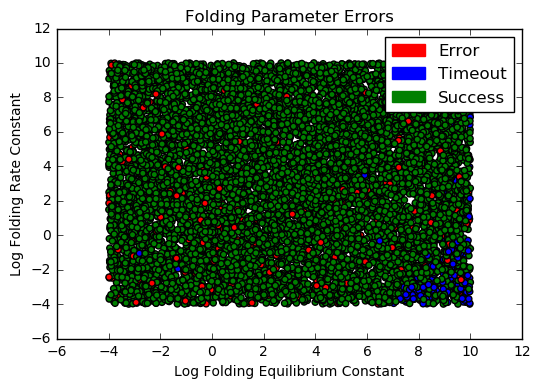

In [16]:
plt.scatter((np.log10(ErrorData[:, 0])), np.log10(ErrorData[:, 1]), c=map(colormap, ErrorData[:, 6]))
plt.ylabel('Log Folding Rate Constant')
plt.xlabel('Log Folding Equilibrium Constant')
plt.title('Folding Parameter Errors')
red_patch = mpatches.Patch(color='red', label='Error')
blue_patch = mpatches.Patch(color='blue', label='Timeout')
green_patch = mpatches.Patch(color='green', label='Success')
plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.show()

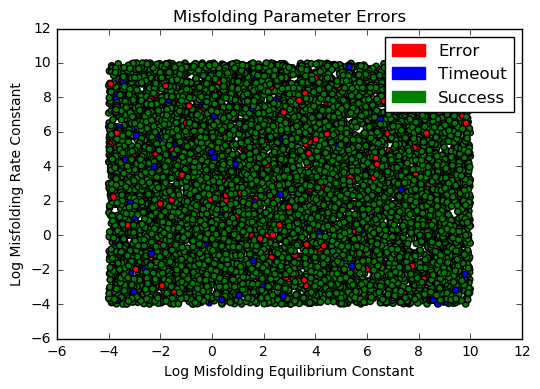

In [17]:
plt.scatter((np.log10(ErrorData[:, 2])), np.log10(ErrorData[:, 3]), c=map(colormap, ErrorData[:, 6]))
plt.ylabel('Log Misfolding Rate Constant')
plt.xlabel('Log Misfolding Equilibrium Constant')
plt.title('Misfolding Parameter Errors')
red_patch = mpatches.Patch(color='red', label='Error')
blue_patch = mpatches.Patch(color='blue', label='Timeout')
green_patch = mpatches.Patch(color='green', label='Success')
plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.show()

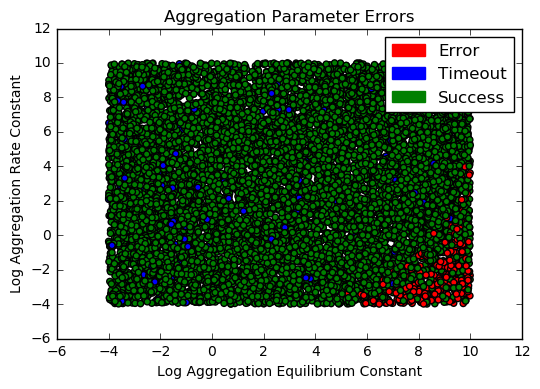

In [18]:
plt.scatter((np.log10(ErrorData[:, 4])), np.log10(ErrorData[:, 5]), c=map(colormap, ErrorData[:, 6]))
plt.ylabel('Log Aggregation Rate Constant')
plt.xlabel('Log Aggregation Equilibrium Constant')
plt.title('Aggregation Parameter Errors')
red_patch = mpatches.Patch(color='red', label='Error')
blue_patch = mpatches.Patch(color='blue', label='Timeout')
green_patch = mpatches.Patch(color='green', label='Success')
plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.show()

## Visual Analysis

*From visual analysis the data appears to separated by a curve. Another classifier like a Support Vector Classifier or Multilayer Perceptron might yield better results.*